In [16]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Layer
import matplotlib.pyplot as plt

In [17]:
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()
subset_size = 1000

X_train, X_test = X_train[:subset_size] / 255.0, X_test[:200] / 255.0
y_train, y_test = y_train[:subset_size], y_test[:200]

In [18]:
def create_model():
    model = Sequential([
            Flatten(input_shape = (28, 28)),
            Dense(64, activation = 'relu'),
            Dense(10, activation = 'softmax')
    ])
    
    model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])
    
    return model

In [32]:
def generate_adviserial_examples(model, X, y, epsilon = 0.1):
    X_tensor = tf.convert_to_tensor(X, dtype = tf.float32)
    y_tensor = tf.convert_to_tensor(y, dtype = tf.int64)
    with tf.GradientTape() as tape:
        tape.watch(X_tensor)
        predictions = model(X_tensor)
        loss = tf.keras.losses.sparse_categorical_crossentropy(y_tensor, predictions)
    gradients = tape.gradient(loss, X_tensor)
    sigmoid_grad = tf.sign(gradients)
    
    X_adv = X_tensor + epsilon + sigmoid_grad
    X_adv = tf.clip_by_value(X_adv, 0, 1)
    
    X_adv = X_adv.numpy()
    return X_adv

In [34]:
model_adv = create_model()
X_adv = generate_adviserial_examples(model_adv, X_train, y_train, epsilon=0.1)
X_combined = np.concatenate([X_train, X_adv])
y_combined = np.concatenate([y_train, y_train])

history_adv = model_adv.fit(X_combined, y_combined, epochs=5, validation_data=(X_test, y_test))
loss_adv, accuracy_adv = model_adv.evaluate(X_test, y_test, verbose=0)
print(f'\nAdversarially Trained Model Accuracy: {accuracy_adv * 100:.2f}%')


Epoch 1/5
63/63 [==============================] - 0s 4ms/step - loss: 2.3467 - accuracy: 0.4235 - val_loss: 1.5944 - val_accuracy: 0.5500
Epoch 2/5
63/63 [==============================] - 0s 2ms/step - loss: 0.8157 - accuracy: 0.8075 - val_loss: 1.0580 - val_accuracy: 0.6750
Epoch 3/5
63/63 [==============================] - 0s 1ms/step - loss: 0.5181 - accuracy: 0.8485 - val_loss: 0.8930 - val_accuracy: 0.7050
Epoch 4/5
63/63 [==============================] - 0s 1ms/step - loss: 0.4223 - accuracy: 0.8720 - val_loss: 0.7841 - val_accuracy: 0.7550
Epoch 5/5
63/63 [==============================] - 0s 1ms/step - loss: 0.3782 - accuracy: 0.8850 - val_loss: 0.7458 - val_accuracy: 0.7250

Adversarially Trained Model Accuracy: 72.50%


In [35]:
class TangentProp(Layer):
    def call(self, x):
        perturbation = tf.random.normal(shape = tf.shape(x), stddev = 0.1)
        return x + perturbation

In [36]:
model_tangent_prop = create_model()
model_tangent_prop.add(TangentProp())

history_tangent_prop = model_tangent_prop.fit(X_train, y_train, epochs = 5, validation_data = (X_test, y_test), verbose = 0)
loss, accuracy_tangent_prop = model_tangent_prop.evaluate(X_test, y_test, verbose = 0)

print(f"\nAdversarially Trained Model with Tangent Prop Accuracy : {accuracy_tangent_prop * 100:.2f}%")


Adversarially Trained Model with Tangent Prop Accuracy : 67.00%


In [37]:
def tangent_distance(x1, x2):
    return np.linalg.norm(x1 - x2)

In [46]:
def classify_with_tangent_distance(X_train, y_train, X_test):
    X_train_flat = X_train.reshape(X_train.shape[0], -1)
    X_test_flat = X_test.reshape(X_test.shape[0], -1)
    y_pred = []

    print(f"\nClassifying {len(X_test_flat)} test samples...")

    for i, test_sample in enumerate(X_test_flat):
        if (i + 1) % 20 == 0:
            print(f"Progress: {i + 1} / {len(X_test_flat)}")

        distances = [tangent_distance(test_sample, train_sample) for train_sample in X_train_flat]
        nearest_index = np.argmin(distances)
        y_pred.append(y_train[nearest_index])

    return np.array(y_pred)

In [47]:
y_pred_tangent = classify_with_tangent_distance(X_train, y_train, X_test)
accuracy_tangent = np.mean(y_pred_tangent == y_test)
print(f"\nTangent Distance Classifier Accuracy : {accuracy_tangent * 100:.2f}%")


Classifying 200 test samples...
Progress: 20 / 200
Progress: 40 / 200
Progress: 60 / 200
Progress: 80 / 200
Progress: 100 / 200
Progress: 120 / 200
Progress: 140 / 200
Progress: 160 / 200
Progress: 180 / 200
Progress: 200 / 200

Tangent Distance Classifier Accuracy : 77.50%


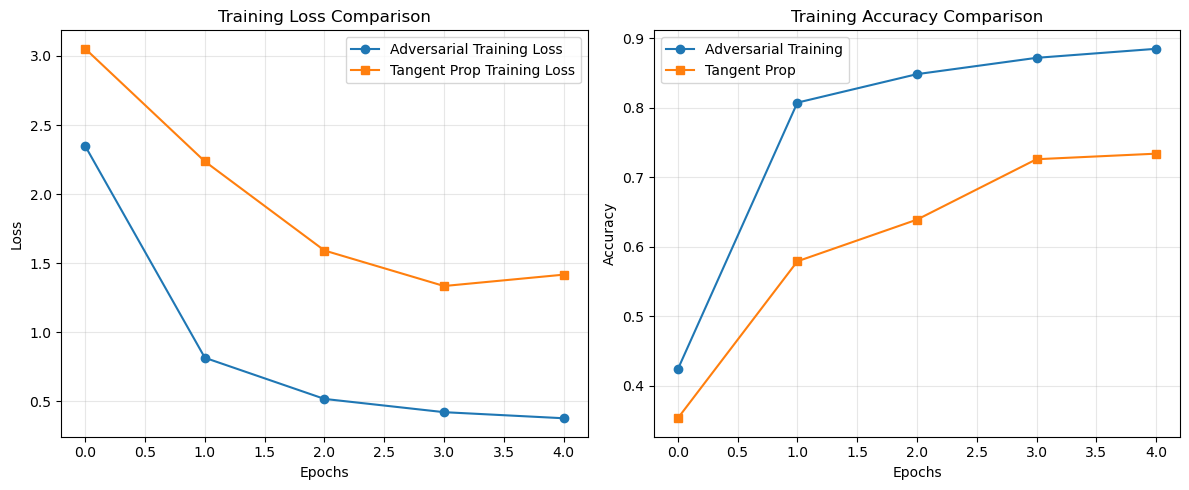

In [48]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history_adv.history['loss'], label='Adversarial Training Loss', marker='o')
plt.plot(history_tangent_prop.history['loss'], label='Tangent Prop Training Loss', marker='s')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Loss Comparison")
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(history_adv.history['accuracy'], label='Adversarial Training', marker='o')
plt.plot(history_tangent_prop.history['accuracy'], label='Tangent Prop', marker='s')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training Accuracy Comparison")
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [49]:
print(f'\nAdversarially Trained Model Accuracy: {accuracy_adv * 100:.2f}%')
print(f"\nTangent Prop Accuracy : {accuracy_tangent_prop * 100:.2f}%")
print(f"\nTangent Distance Classifier Accuracy : {accuracy_tangent * 100:.2f}%")


Adversarially Trained Model Accuracy: 72.50%

Tangent Prop Accuracy : 67.00%

Tangent Distance Classifier Accuracy : 77.50%
